<a href="https://colab.research.google.com/github/makrez/BioinformaticsTools/blob/master/Variational_Autoencoder_16S.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Variational Autoencoder

In [ ]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder
!pip install biopython
from Bio import SeqIO
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
!pip install umap-learn
import umap
import matplotlib.pyplot as plt
import os
from sklearn.decomposition import PCA
!pip install torchviz
from torchviz import make_dot
#os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import pandas as pd
import seaborn as sns

Mount drive

In [ ]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Load the data

In [ ]:
class hot_dna:
    def __init__(self, sequence):
        sequence = sequence.upper()
        self.sequence = self._preprocess_sequence(sequence)
        self.category_mapping = {'A': 0, 'C': 1, 'G': 2, 'T': 3, 'U': 3, '-': 4, 'N': 5}
        self.onehot = self._onehot_encode(self.sequence)

    def _preprocess_sequence(self, sequence):
        ambiguous_bases = {'R', 'Y', 'S', 'W', 'K', 'M', 'B', 'D', 'H', 'V'}
        new_sequence = ""
        for base in sequence:
            if base in ambiguous_bases:
                new_sequence += 'N'
            else:
                new_sequence += base
        return new_sequence

    def _onehot_encode(self, sequence):
        integer_encoded = np.array([self.category_mapping[char] for char in sequence]).reshape(-1, 1)
        onehot_encoder = OneHotEncoder(sparse=False, categories='auto', handle_unknown='ignore')
        onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
        
        full_onehot_encoded = np.zeros((len(sequence), 6))
        full_onehot_encoded[:, :onehot_encoded.shape[1]] = onehot_encoded
        
        return full_onehot_encoded

flatted_sequence = list()
sequence_labels = list()

alignment_length = 1500

with open('/content/drive/MyDrive/Colab Notebooks/autoencoder_data/bacillus.aln') as handle:
    for record in SeqIO.parse(handle, 'fasta'):
        label = str(record.description).rsplit(';', 1)[-1]
        seq_hot = hot_dna(str(record.seq)[10:alignment_length+10]).onehot
        
        if len(seq_hot) == alignment_length:
            flatted_sequence.append(seq_hot)
            sequence_labels.append(label)

In [ ]:
class SequenceDataset(Dataset):
    def __init__(self, sequences):
        self.sequences = sequences

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, index):
        return self.sequences[index]

Build the Variational autoencoder

In [ ]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, input_length, latent_dim):
        super(VariationalAutoencoder, self).__init__()
        self.input_length = input_length

        # Encoding layers
        self.encoder = nn.Sequential(
            nn.Conv1d(6, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(2, stride=2),
            nn.Conv1d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(2, stride=2),
            nn.Conv1d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(2, stride=2),
            nn.Conv1d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(2, stride=2)
        )

        self.encoder_output_dim = 256 * 93
        self.fc_mu = nn.Linear(self.encoder_output_dim, latent_dim)
        self.fc_var = nn.Linear(self.encoder_output_dim, latent_dim)

        # Decoding layers
        self.decoder_input_dim = self.encoder_output_dim
        self.fc_dec = nn.Linear(latent_dim, self.decoder_input_dim)

        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(256, 128, kernel_size=4, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose1d(128, 64, kernel_size=4, stride=2, padding=1, output_padding=0),
            nn.ReLU(inplace=True),
            nn.ConvTranspose1d(64, 32, kernel_size=4, stride=2, padding=1, output_padding=0),
            nn.ReLU(inplace=True),
            nn.ConvTranspose1d(32, 32, kernel_size=753, stride=1, padding=0),
            nn.ReLU(inplace=True),
            nn.ConvTranspose1d(32, 6, kernel_size=1, stride=1, padding=0),
            nn.Sigmoid()
        )


        # Initialize weights
        self.apply(self.init_weights)

    def init_weights(self, m):
        if isinstance(m, nn.Conv1d) or isinstance(m, nn.ConvTranspose1d):
            nn.init.kaiming_normal_(m.weight)

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def encode(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        log_var = self.fc_var(x)
        return mu, log_var

    def decode(self, z):
        x = self.fc_dec(z)
        x = x.view(x.size(0), 256, -1)
        x = self.decoder(x)
        return x

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_recon = self.decode(z)
        return x_recon, mu, log_var

def is_binary(tensor):
    unique_vals = torch.unique(tensor)
    return torch.all((unique_vals == 0) | (unique_vals == 1))

def vae_loss(x, x_recon, mu, log_var):
    #print(x.shape, x_recon.shape)
    assert not torch.isnan(x).any()
    assert not torch.isnan(x_recon).any()
    assert not torch.isinf(x).any()
    assert not torch.isinf(x_recon).any()
    assert is_binary(x), "Target tensor contains non-binary values"
    BCE = F.binary_cross_entropy(x_recon, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD


Train the model

In [ ]:
def train_model(model, optimizer, train_dataloader, val_dataloader, device, n_epochs):
    train_losses = []
    val_losses = []

    for epoch in range(1, n_epochs + 1):
        train_loss = 0.0
        val_loss = 0.0

        # Training loop
        model.train()
        for batch_idx, data in enumerate(train_dataloader):
            # Transform the data tensor to have the shape (batch_size, n_channels, sequence_length)
            data = data.permute(0, 2, 1)
            data = data.float().to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            x_recon, mu, log_var = model(data)

            # Compute the loss
            loss = vae_loss(data, x_recon, mu, log_var)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Update the training loss
            train_loss += loss.item() * data.size(0)

        # Print the average training loss for the epoch
        train_loss /= len(train_dataloader.dataset)

        # Validation loop
        model.eval()
        with torch.no_grad():
            for batch_idx, data in enumerate(val_dataloader):
              # Transform the data tensor to have the shape (batch_size, n_channels, sequence_length)
              data = data.permute(0, 2, 1)
              data = data.float().to(device)

              # Forward pass
              x_recon, mu, log_var = model(data)

              # Compute the loss
              loss = vae_loss(data, x_recon, mu, log_var)

              # Update the validation loss
              val_loss += loss.item() * data.size(0)

        val_loss /= len(val_dataloader.dataset)

        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, train_loss, val_loss))
        
        # Append the training loss to the list
        train_losses.append(train_loss)
        val_losses.append(val_loss)

    return train_losses, val_losses

Plotting Functions


In [ ]:
from sklearn.decomposition import PCA
from matplotlib.lines import Line2D

def plot_latent_space(model, device, flatted_sequence, sequence_labels, latent_space_dim, hyperparameters):
    model.eval()

    latent_vectors = []
    labels = []

    for sequence, label in zip(flatted_sequence, sequence_labels):
        sequence = torch.from_numpy(sequence).unsqueeze(0).permute(0, 2, 1)
        sequence = sequence.float().to(device)

        mu, _ = model.encode(sequence)
        mu = mu.detach().cpu().numpy()

        latent_vectors.append(mu)
        labels.append(label)

    latent_vectors_array = np.array(latent_vectors).squeeze()

    # Apply UMAP dimensionality reduction
    if latent_space_dim > 2:
        umap_model = umap.UMAP()
        umap_coords = umap_model.fit_transform(latent_vectors_array)
    else:
        umap_coords = latent_vectors_array

    # Apply PCA dimensionality reduction
    pca_model = PCA(n_components=2)
    pca_coords = pca_model.fit_transform(latent_vectors_array)

    unique_labels = set(labels)
    color_dict = {label: plt.cm.tab20(i) for i, label in enumerate(unique_labels)}

    # Create legend elements
    legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color_dict[label], markersize=10, label=label) for label in unique_labels]

    fig, axes = plt.subplots(1, 2, figsize=(20, 10))

    for ax, coords, method in zip(axes, [umap_coords, pca_coords], ["UMAP", "PCA"]):
        for label in unique_labels:
            indices = [i for i, x in enumerate(labels) if x == label]
            coords_subset = coords[indices]
            color = color_dict[label]

            ax.scatter(coords_subset[:, 0], coords_subset[:, 1], color=color, label=label)
        
        ax.set_title(f"{method} | Latent Dim: {hyperparameters['latent_dim']} | Learning Rate: {hyperparameters['learning_rate']} | Epochs: {hyperparameters['n_epochs']}")

    # Add the legend to the figure in the middle of the two subplots
    fig.legend(handles=legend_elements, loc='center right')

    os.makedirs(os.path.join(os.getcwd(), "vae_plots"), exist_ok=True)
    filename = f"latent_dim_{hyperparameters['latent_dim']}_lr_{hyperparameters['learning_rate']}_n_epochs_{hyperparameters['n_epochs']}.png"
    plt.savefig(os.path.join(os.getcwd() , "vae_plots", filename), bbox_inches="tight")

    plt.show()



def plot_loss(train_losses, val_losses, hyperparameters):
    plt.figure()
    plt.plot(train_losses, label="Training Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Latent Dim: {hyperparameters['latent_dim']} | Learning Rate: {hyperparameters['learning_rate']} | Epochs: {hyperparameters['n_epochs']}")
    plt.legend()
    os.makedirs(os.path.join(os.getcwd(), "vae_plots"), exist_ok=True)
    filename = f"loss_latent_dim_{hyperparameters['latent_dim']}_lr_{hyperparameters['learning_rate']}_n_epochs_{hyperparameters['n_epochs']}.png"
    plt.savefig(os.path.join(os.getcwd() , "vae_plots", filename), bbox_inches="tight")
    plt.show()

Main function

Epoch: 1 	Training Loss: 373908.482862 	Validation Loss: 35266.552014
Epoch: 2 	Training Loss: 12372.101067 	Validation Loss: 5860.584076
Epoch: 3 	Training Loss: 6313.517427 	Validation Loss: 4501.207891
Epoch: 4 	Training Loss: 3897.939321 	Validation Loss: 2247.093541
Epoch: 5 	Training Loss: 2932.833565 	Validation Loss: 2064.554673
Epoch: 6 	Training Loss: 2594.382983 	Validation Loss: 1744.292329
Epoch: 7 	Training Loss: 2379.872070 	Validation Loss: 1591.128924
Epoch: 8 	Training Loss: 2179.003776 	Validation Loss: 1613.496251
Epoch: 9 	Training Loss: 2083.154279 	Validation Loss: 1452.735899
Epoch: 10 	Training Loss: 1944.033513 	Validation Loss: 1412.516719
Epoch: 11 	Training Loss: 1825.547367 	Validation Loss: 1364.729234
Epoch: 12 	Training Loss: 1696.037694 	Validation Loss: 1273.911696
Epoch: 13 	Training Loss: 1617.454268 	Validation Loss: 1280.277892
Epoch: 14 	Training Loss: 1710.468053 	Validation Loss: 1242.180180
Epoch: 15 	Training Loss: 1666.090425 	Validation Los

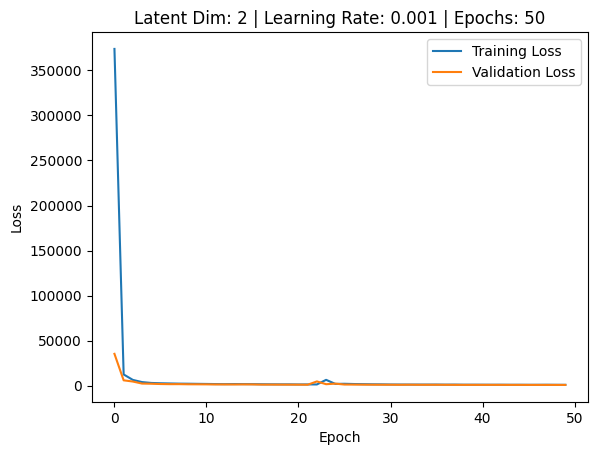

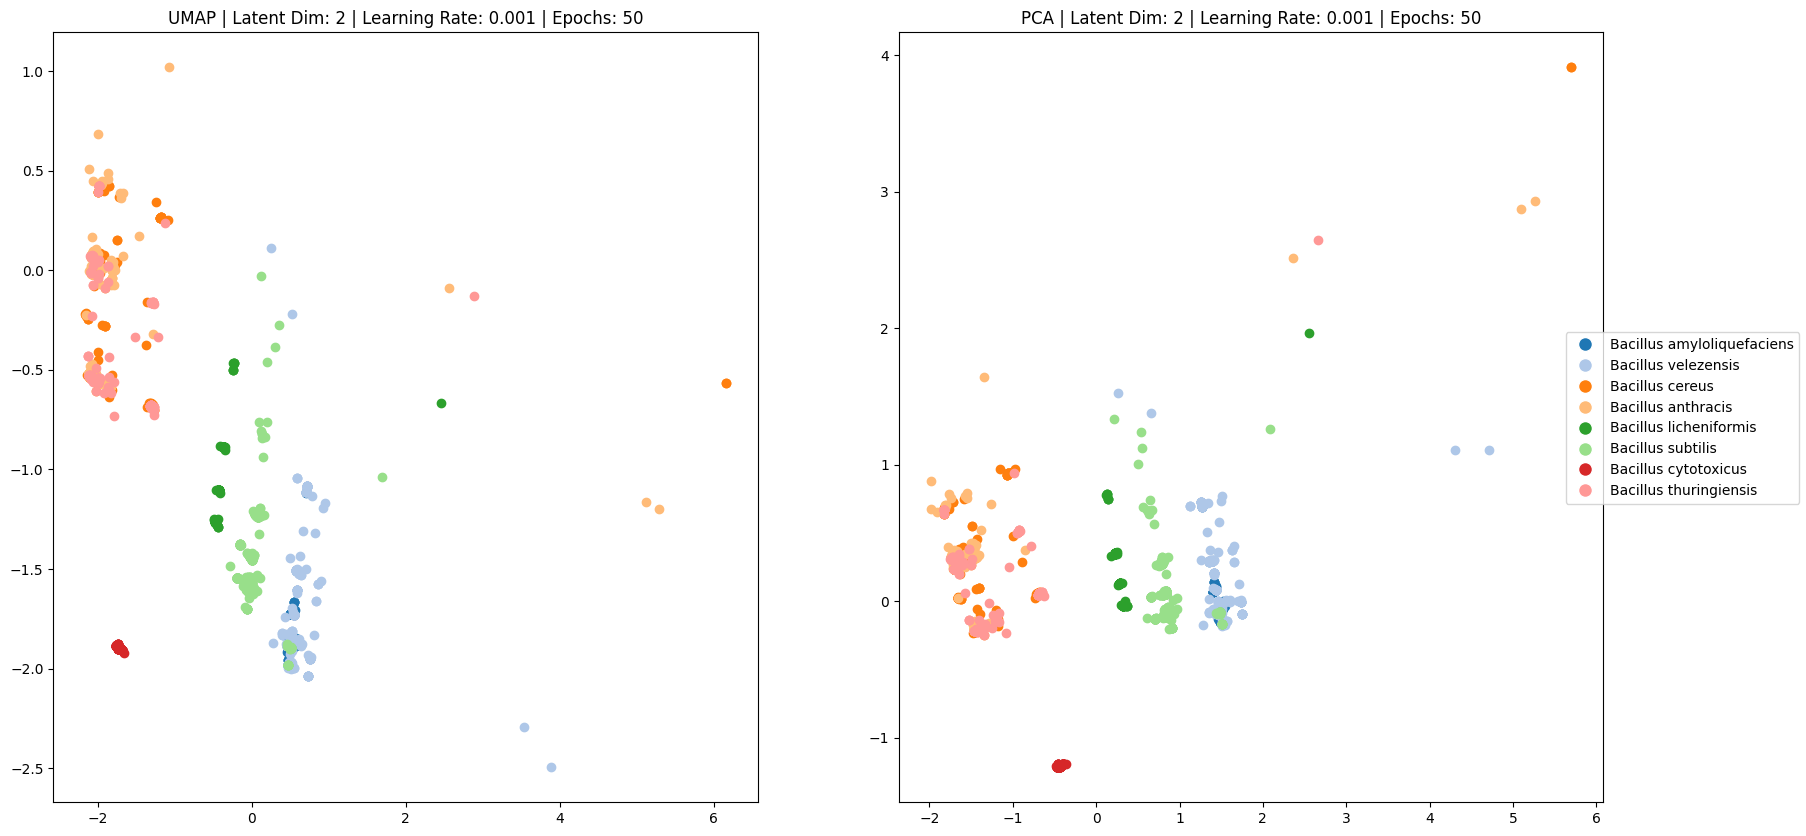

<ipython-input-9-579d99752fda>:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  loss_values = loss_values.append({


Epoch: 1 	Training Loss: 86159.956867 	Validation Loss: 16290.621356
Epoch: 2 	Training Loss: 9016.353737 	Validation Loss: 7146.335259
Epoch: 3 	Training Loss: 5304.494464 	Validation Loss: 4490.953338
Epoch: 4 	Training Loss: 3566.214318 	Validation Loss: 3716.304645
Epoch: 5 	Training Loss: 3068.366585 	Validation Loss: 3323.372982
Epoch: 6 	Training Loss: 2735.359489 	Validation Loss: 3172.952578
Epoch: 7 	Training Loss: 2479.694339 	Validation Loss: 3056.752130
Epoch: 8 	Training Loss: 2298.202439 	Validation Loss: 3027.185163
Epoch: 9 	Training Loss: 2181.347176 	Validation Loss: 2721.175001
Epoch: 10 	Training Loss: 2072.944670 	Validation Loss: 2555.102976
Epoch: 11 	Training Loss: 1985.908933 	Validation Loss: 2504.932711
Epoch: 12 	Training Loss: 1929.932456 	Validation Loss: 2471.766528
Epoch: 13 	Training Loss: 1826.690043 	Validation Loss: 2533.149062
Epoch: 14 	Training Loss: 1808.811548 	Validation Loss: 2278.693329
Epoch: 15 	Training Loss: 1719.147897 	Validation Loss:

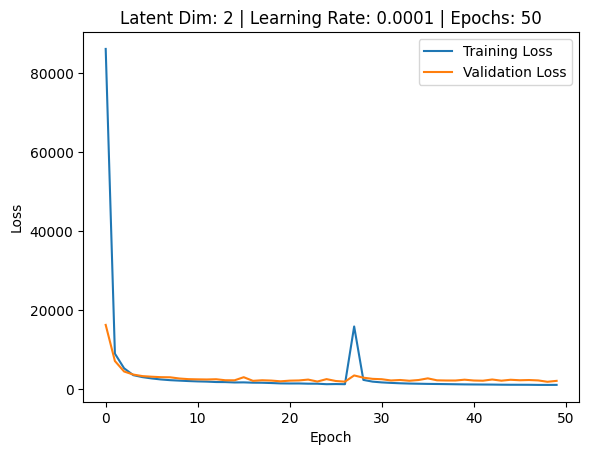

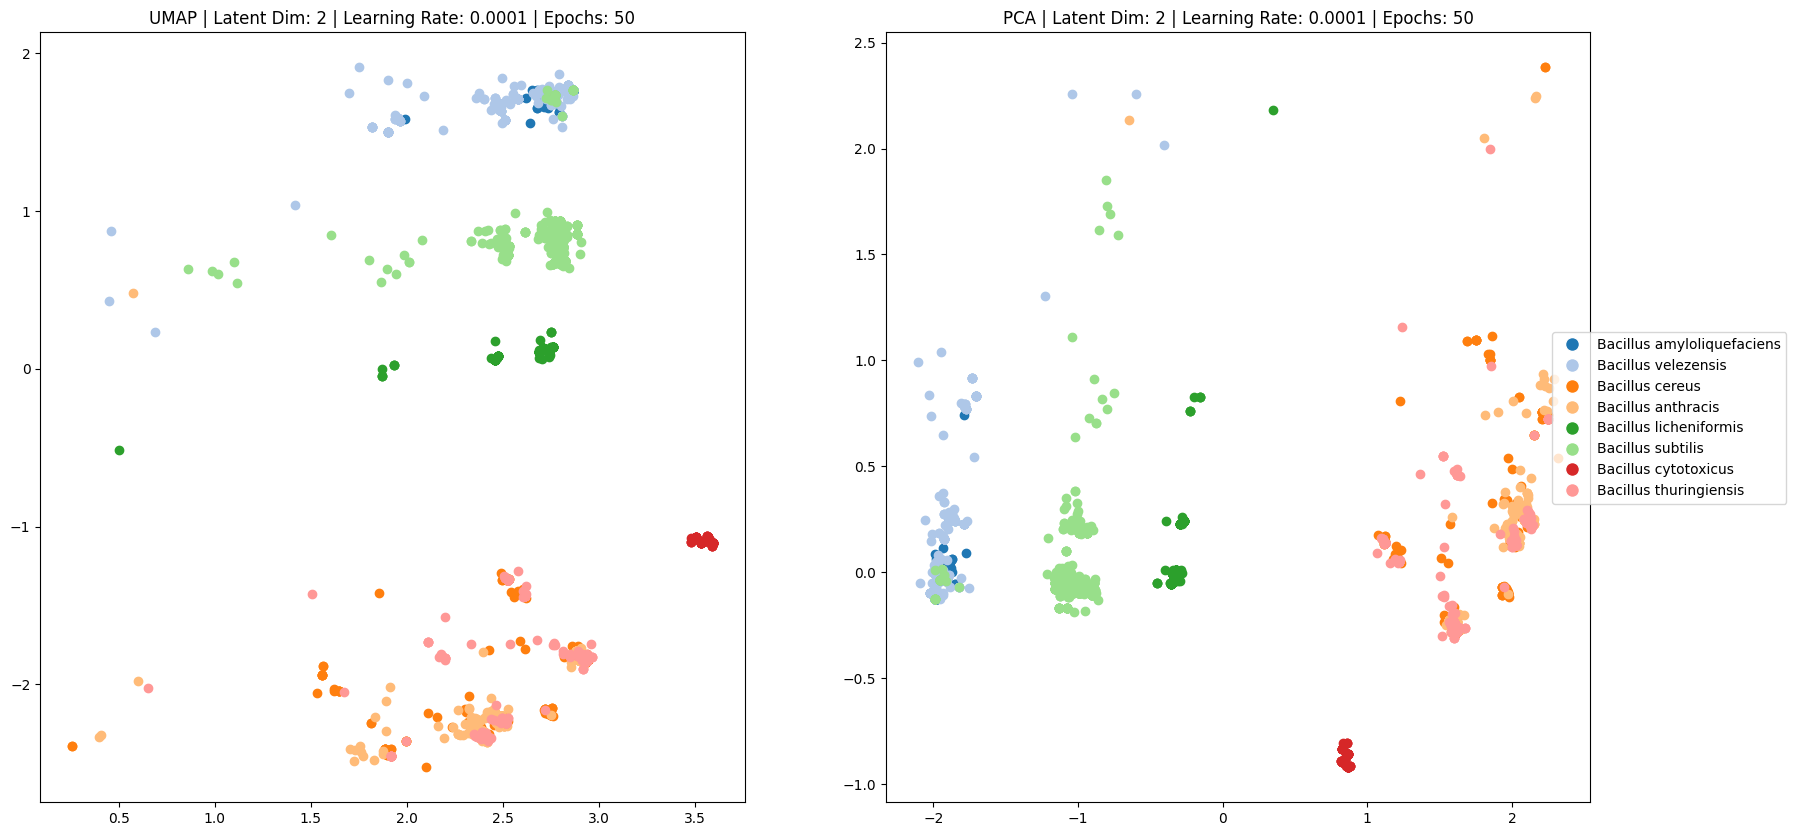

<ipython-input-9-579d99752fda>:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  loss_values = loss_values.append({


Epoch: 1 	Training Loss: 137547.247629 	Validation Loss: 117361.061275
Epoch: 2 	Training Loss: 109085.358096 	Validation Loss: 95668.104696
Epoch: 3 	Training Loss: 83739.116900 	Validation Loss: 66956.185124
Epoch: 4 	Training Loss: 47174.574280 	Validation Loss: 25163.348785
Epoch: 5 	Training Loss: 14424.382770 	Validation Loss: 12145.148249
Epoch: 6 	Training Loss: 9140.701080 	Validation Loss: 10654.931787
Epoch: 7 	Training Loss: 7947.598199 	Validation Loss: 9571.915919
Epoch: 8 	Training Loss: 6998.388873 	Validation Loss: 8677.518388
Epoch: 9 	Training Loss: 6067.762675 	Validation Loss: 7639.032934
Epoch: 10 	Training Loss: 5397.800823 	Validation Loss: 7224.622853
Epoch: 11 	Training Loss: 4918.870110 	Validation Loss: 6666.249061
Epoch: 12 	Training Loss: 4632.984137 	Validation Loss: 6483.857460
Epoch: 13 	Training Loss: 4347.352939 	Validation Loss: 6276.452179
Epoch: 14 	Training Loss: 4139.319199 	Validation Loss: 5766.543835
Epoch: 15 	Training Loss: 3976.346799 	Vali

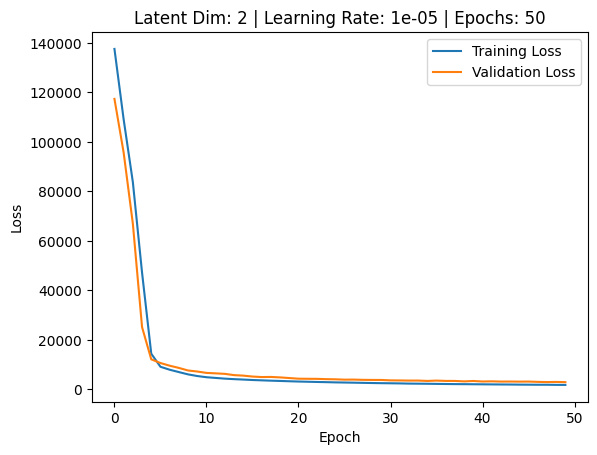

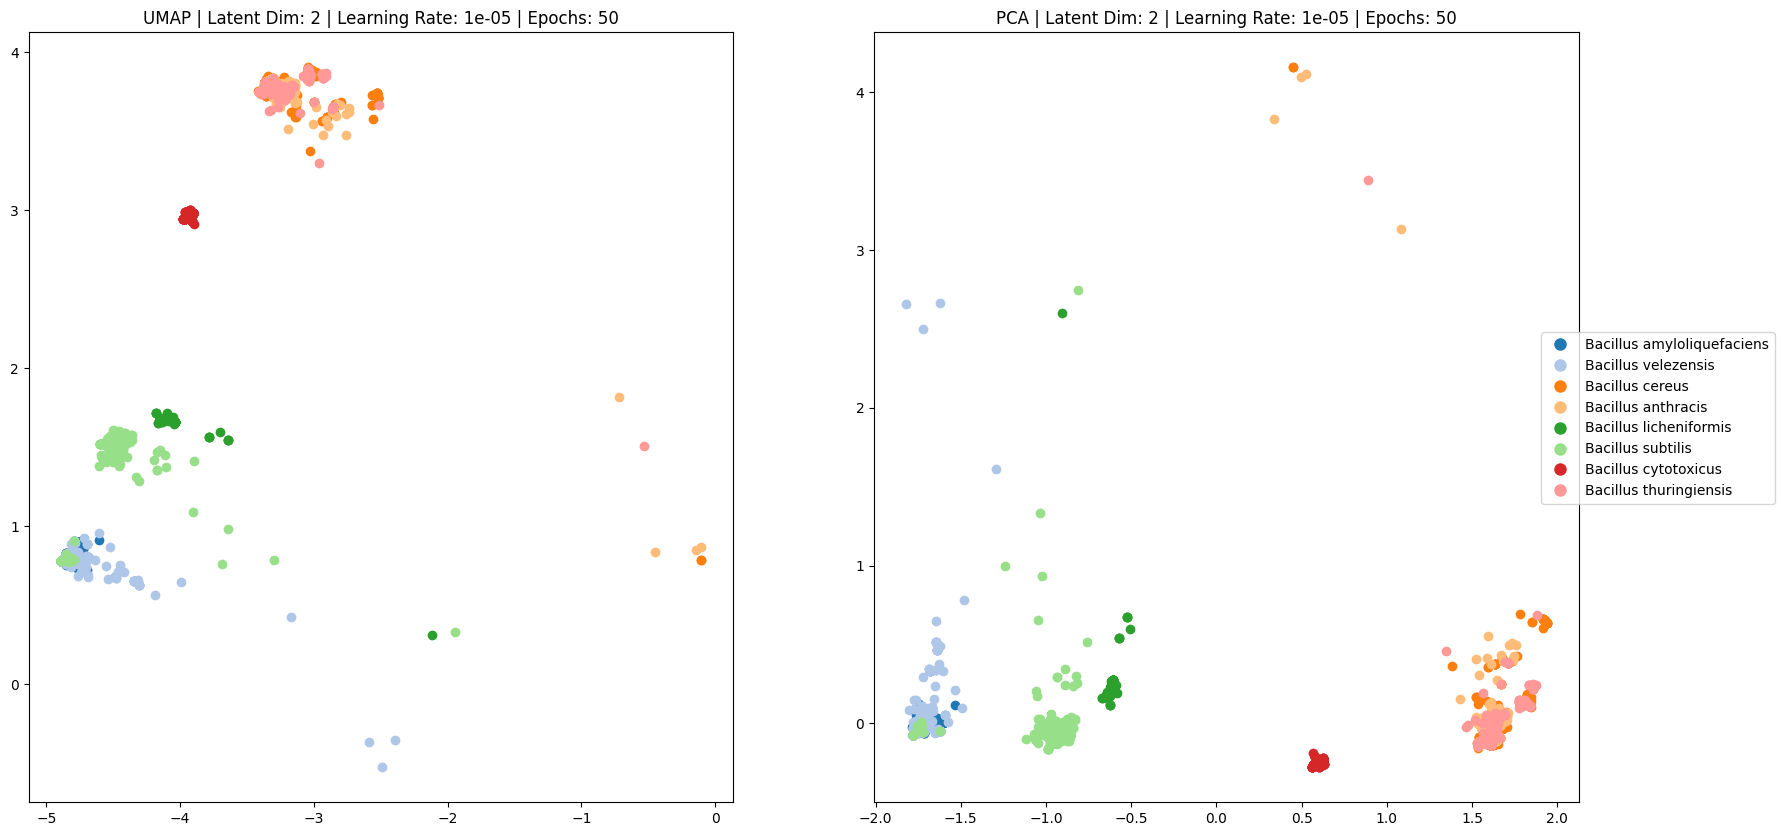

<ipython-input-9-579d99752fda>:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  loss_values = loss_values.append({


Epoch: 1 	Training Loss: 350851.688072 	Validation Loss: 57256.903205
Epoch: 2 	Training Loss: 17337.702886 	Validation Loss: 8013.500617
Epoch: 3 	Training Loss: 6159.605733 	Validation Loss: 4337.316034
Epoch: 4 	Training Loss: 3881.603025 	Validation Loss: 3480.102449
Epoch: 5 	Training Loss: 3201.295006 	Validation Loss: 2928.613317
Epoch: 6 	Training Loss: 2806.962229 	Validation Loss: 2577.505561
Epoch: 7 	Training Loss: 2641.603192 	Validation Loss: 2531.822585
Epoch: 8 	Training Loss: 2406.957679 	Validation Loss: 2381.094266
Epoch: 9 	Training Loss: 2314.240661 	Validation Loss: 2099.951891
Epoch: 10 	Training Loss: 2099.137999 	Validation Loss: 1948.141277
Epoch: 11 	Training Loss: 2045.720856 	Validation Loss: 1883.039840
Epoch: 12 	Training Loss: 1887.279168 	Validation Loss: 2016.022071
Epoch: 13 	Training Loss: 2021.392375 	Validation Loss: 1830.876363
Epoch: 14 	Training Loss: 1842.581481 	Validation Loss: 1787.722058
Epoch: 15 	Training Loss: 1832.937186 	Validation Los

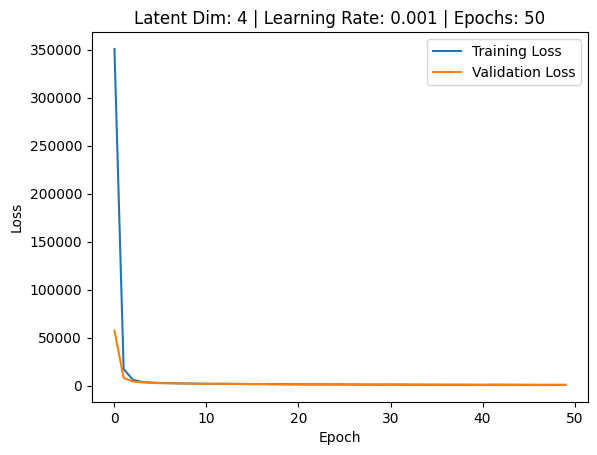

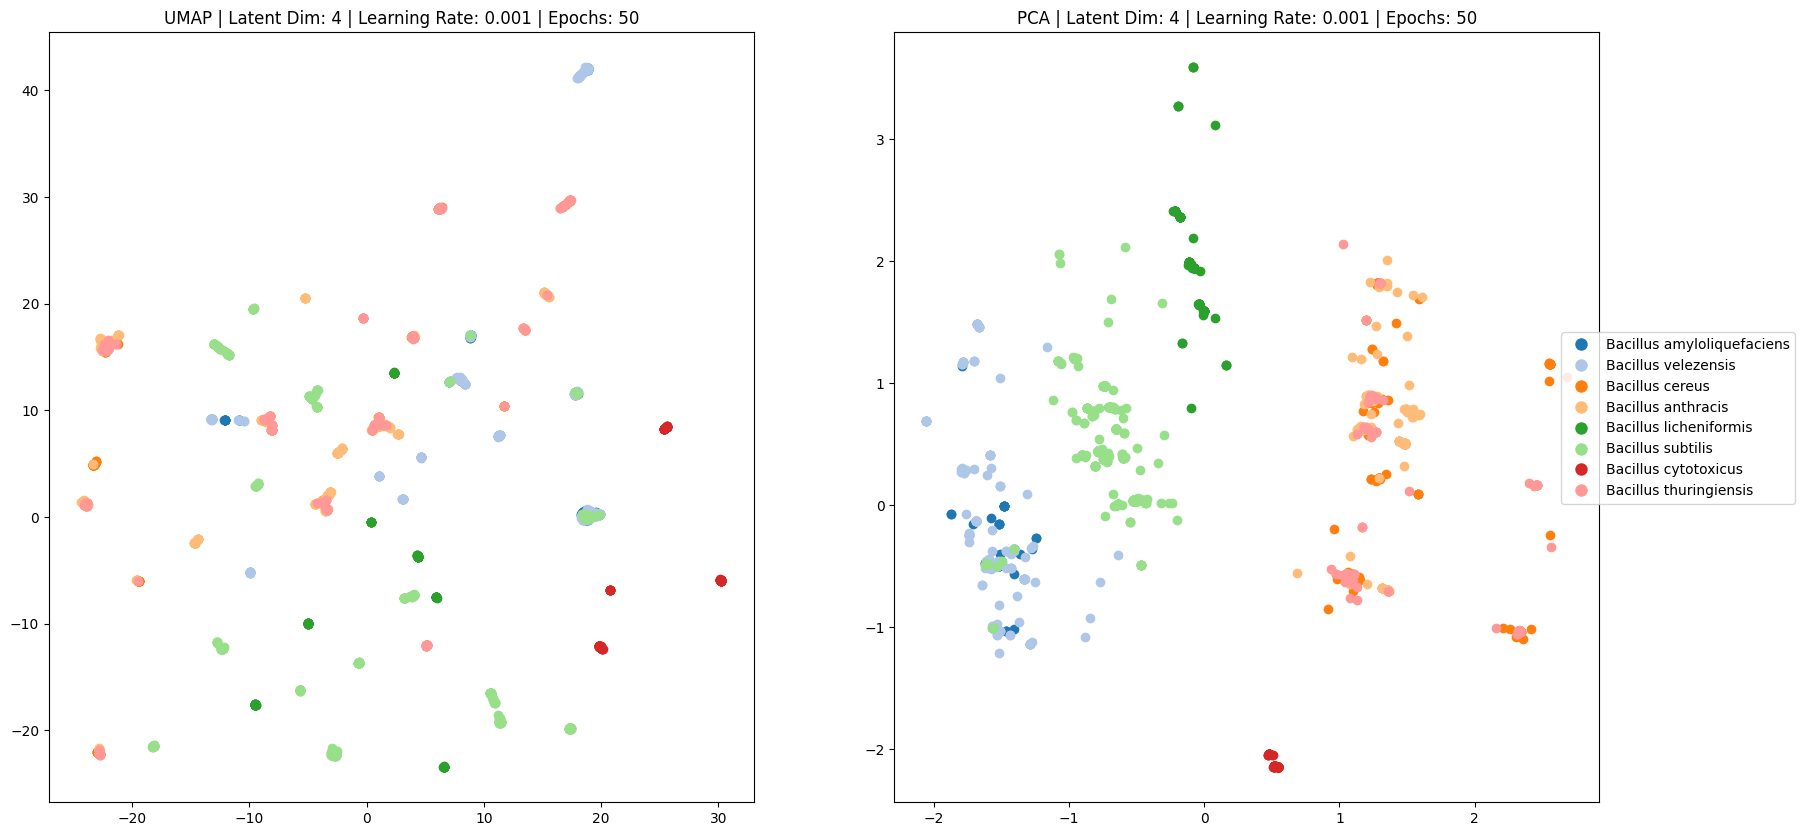

<ipython-input-9-579d99752fda>:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  loss_values = loss_values.append({


Epoch: 1 	Training Loss: 111325.309809 	Validation Loss: 66262.177734
Epoch: 2 	Training Loss: 22235.808163 	Validation Loss: 7799.621783
Epoch: 3 	Training Loss: 6801.966176 	Validation Loss: 4889.752375
Epoch: 4 	Training Loss: 4343.605040 	Validation Loss: 3593.802367
Epoch: 5 	Training Loss: 3583.552794 	Validation Loss: 3085.681202
Epoch: 6 	Training Loss: 3062.387714 	Validation Loss: 2729.233807
Epoch: 7 	Training Loss: 2775.782460 	Validation Loss: 2549.303968
Epoch: 8 	Training Loss: 2567.764805 	Validation Loss: 2409.626203
Epoch: 9 	Training Loss: 2368.943153 	Validation Loss: 2213.385068
Epoch: 10 	Training Loss: 2201.693758 	Validation Loss: 2097.226854
Epoch: 11 	Training Loss: 2075.353331 	Validation Loss: 1956.709226
Epoch: 12 	Training Loss: 1991.864875 	Validation Loss: 1840.638862
Epoch: 13 	Training Loss: 1898.185985 	Validation Loss: 1786.533668
Epoch: 14 	Training Loss: 1794.599365 	Validation Loss: 1842.514761
Epoch: 15 	Training Loss: 1724.043708 	Validation Los

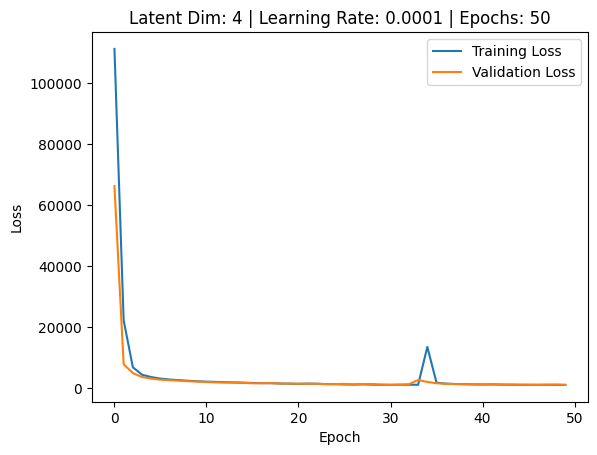

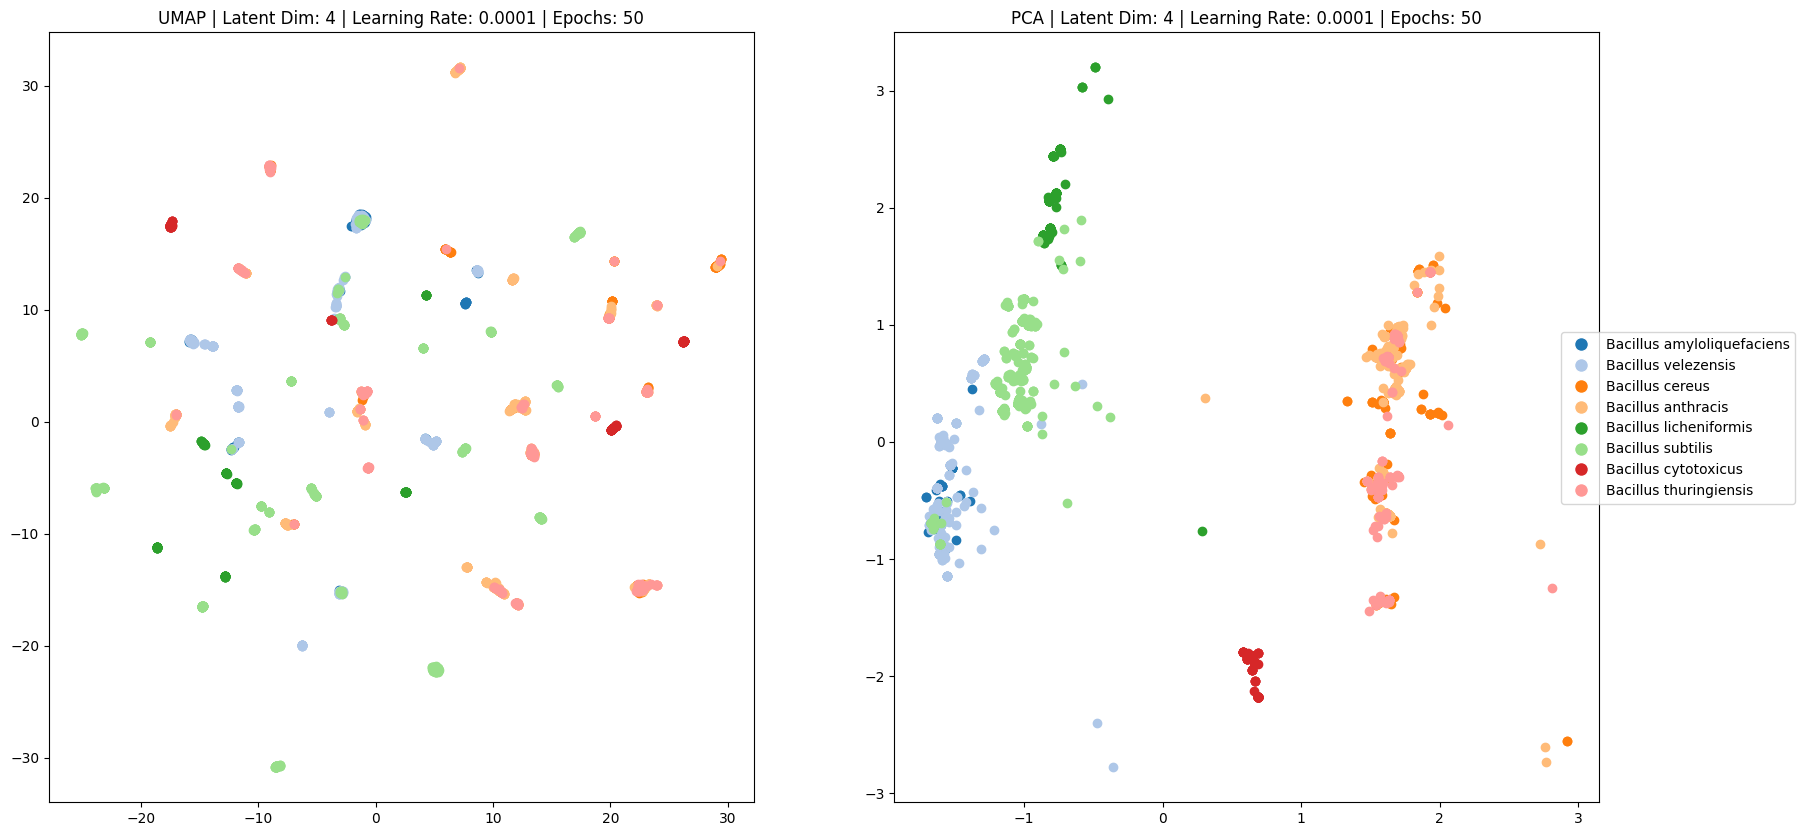

<ipython-input-9-579d99752fda>:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  loss_values = loss_values.append({


Epoch: 1 	Training Loss: 140170.582866 	Validation Loss: 118538.300833
Epoch: 2 	Training Loss: 109038.102862 	Validation Loss: 93166.346884
Epoch: 3 	Training Loss: 73773.564444 	Validation Loss: 46240.166807
Epoch: 4 	Training Loss: 26397.311222 	Validation Loss: 15830.928826
Epoch: 5 	Training Loss: 12968.337922 	Validation Loss: 12182.036359
Epoch: 6 	Training Loss: 10564.005251 	Validation Loss: 10530.112971
Epoch: 7 	Training Loss: 9104.999321 	Validation Loss: 9346.345534
Epoch: 8 	Training Loss: 8001.751705 	Validation Loss: 8387.307326
Epoch: 9 	Training Loss: 7189.294083 	Validation Loss: 7703.777676
Epoch: 10 	Training Loss: 6543.618341 	Validation Loss: 7149.342338
Epoch: 11 	Training Loss: 6024.038209 	Validation Loss: 6742.568372
Epoch: 12 	Training Loss: 5616.509659 	Validation Loss: 6404.140751
Epoch: 13 	Training Loss: 5261.366231 	Validation Loss: 6025.633641
Epoch: 14 	Training Loss: 4961.921631 	Validation Loss: 5751.453799
Epoch: 15 	Training Loss: 4695.742784 	Val

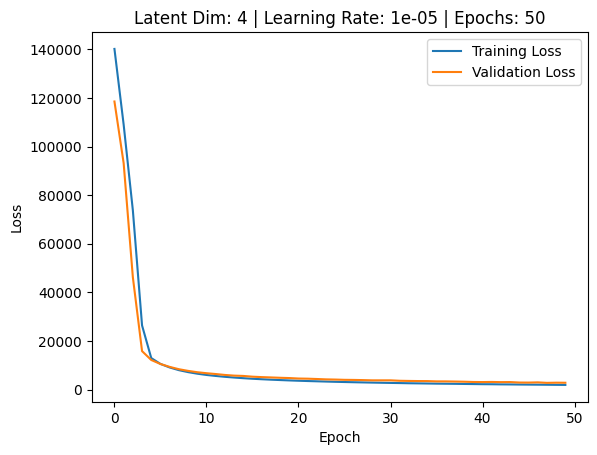

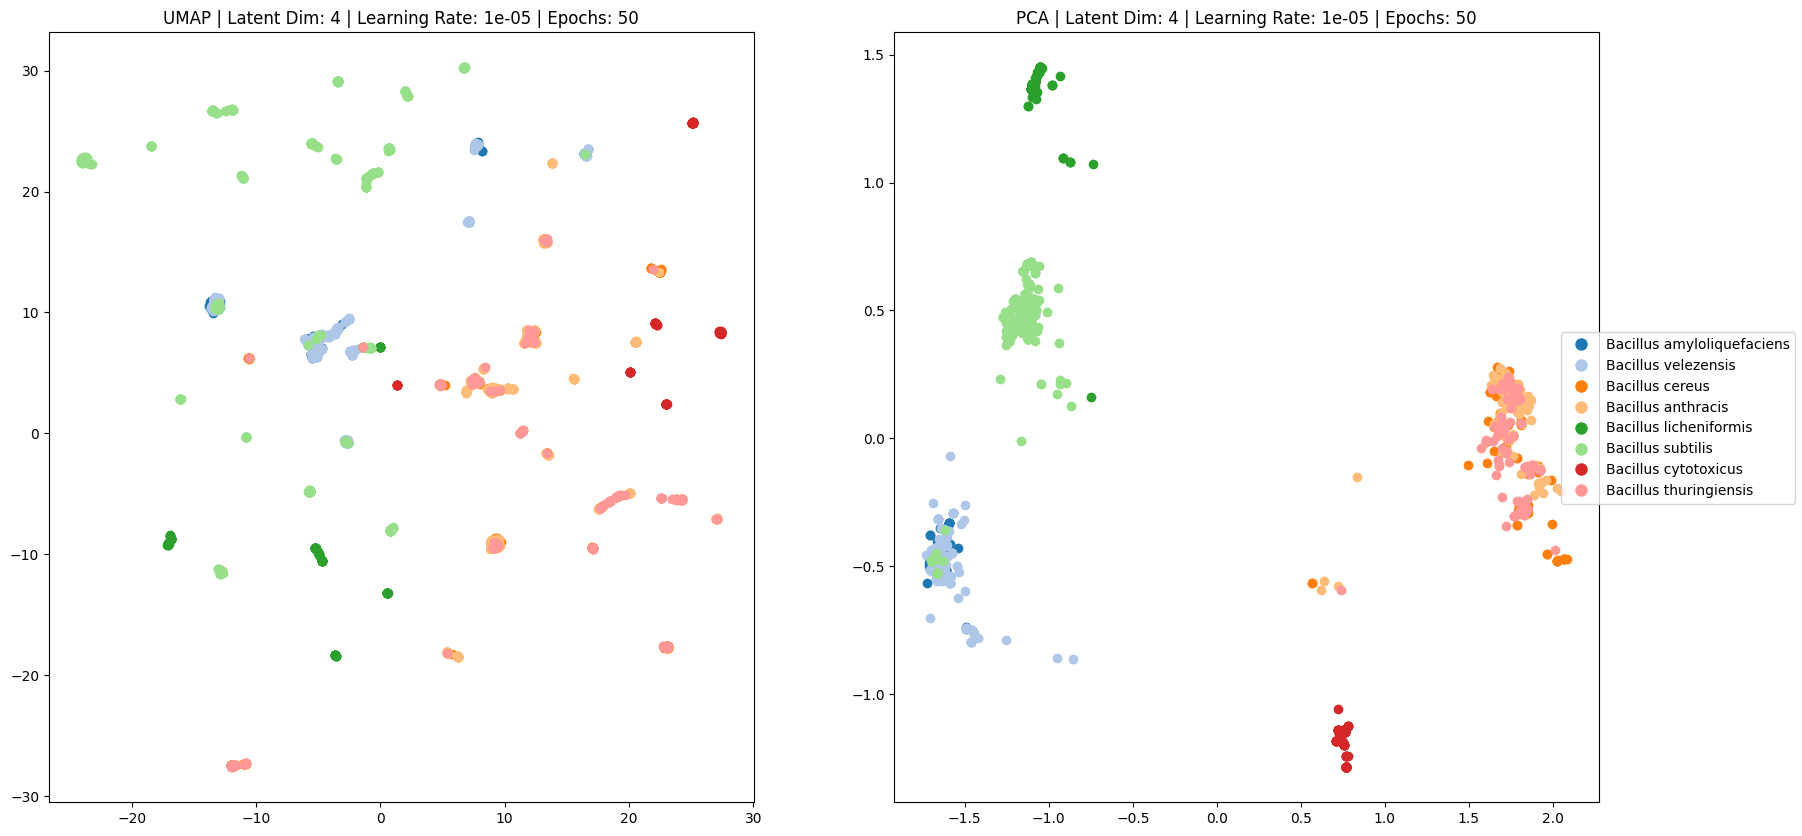

<ipython-input-9-579d99752fda>:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  loss_values = loss_values.append({


Epoch: 1 	Training Loss: 177374.883244 	Validation Loss: 40844.256197
Epoch: 2 	Training Loss: 11992.635462 	Validation Loss: 6968.639137
Epoch: 3 	Training Loss: 5718.859587 	Validation Loss: 5353.316275
Epoch: 4 	Training Loss: 3636.807546 	Validation Loss: 3822.654003
Epoch: 5 	Training Loss: 2883.442671 	Validation Loss: 3345.732485
Epoch: 6 	Training Loss: 2539.510096 	Validation Loss: 3575.126434
Epoch: 7 	Training Loss: 2510.065980 	Validation Loss: 2972.611393
Epoch: 8 	Training Loss: 2512.532248 	Validation Loss: 2796.690892
Epoch: 9 	Training Loss: 2240.865206 	Validation Loss: 3144.232458
Epoch: 10 	Training Loss: 2344.040865 	Validation Loss: 2989.614711
Epoch: 11 	Training Loss: 2139.067672 	Validation Loss: 2541.201812
Epoch: 12 	Training Loss: 2164.170868 	Validation Loss: 2502.561084
Epoch: 13 	Training Loss: 1950.896748 	Validation Loss: 2443.580195
Epoch: 14 	Training Loss: 1936.510819 	Validation Loss: 2473.092071
Epoch: 15 	Training Loss: 1829.490263 	Validation Los

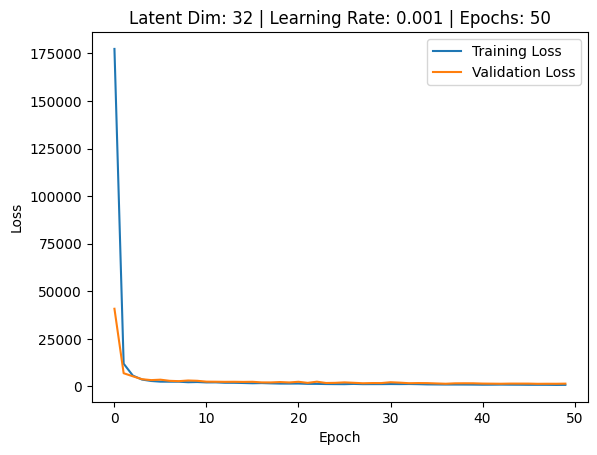

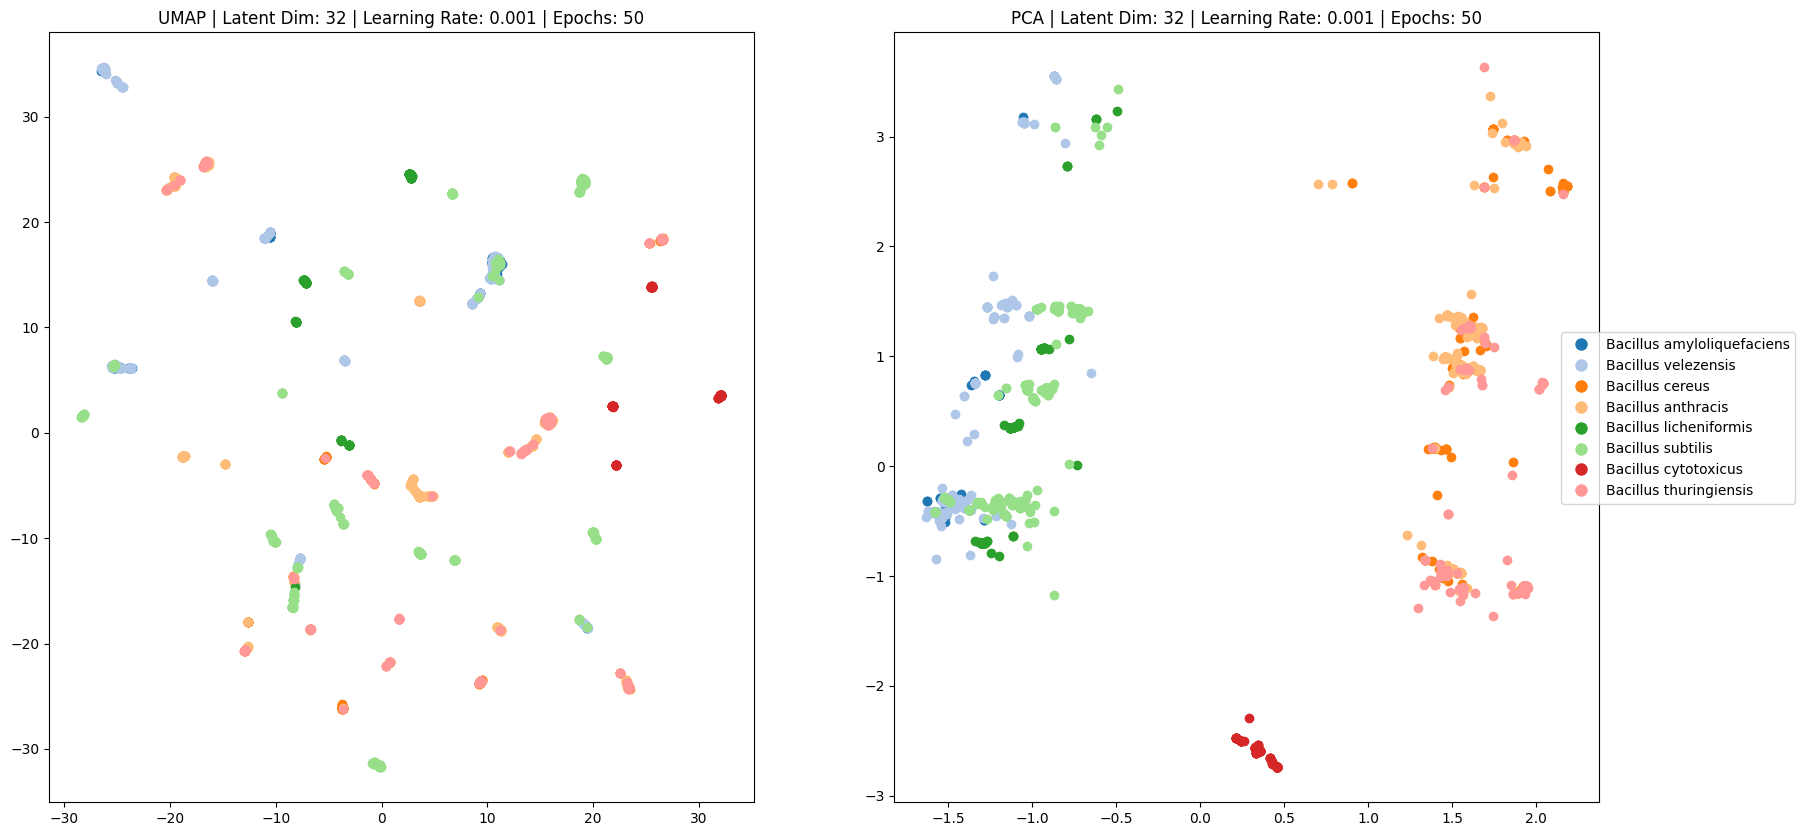

<ipython-input-9-579d99752fda>:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  loss_values = loss_values.append({


Epoch: 1 	Training Loss: 101417.543299 	Validation Loss: 26115.745418
Epoch: 2 	Training Loss: 15394.083965 	Validation Loss: 9617.757519
Epoch: 3 	Training Loss: 8143.206384 	Validation Loss: 6138.740058
Epoch: 4 	Training Loss: 5860.948690 	Validation Loss: 4703.551923
Epoch: 5 	Training Loss: 4804.997820 	Validation Loss: 3906.499254
Epoch: 6 	Training Loss: 4140.530689 	Validation Loss: 3379.604700
Epoch: 7 	Training Loss: 3725.802417 	Validation Loss: 3146.086103
Epoch: 8 	Training Loss: 3360.428285 	Validation Loss: 2787.554114
Epoch: 9 	Training Loss: 3132.506032 	Validation Loss: 2488.367625
Epoch: 10 	Training Loss: 2941.461410 	Validation Loss: 2432.905472
Epoch: 11 	Training Loss: 2624.594194 	Validation Loss: 2112.481926
Epoch: 12 	Training Loss: 2659.696097 	Validation Loss: 2076.798704
Epoch: 13 	Training Loss: 2334.959010 	Validation Loss: 1922.846464
Epoch: 14 	Training Loss: 2296.993358 	Validation Loss: 1845.637788
Epoch: 15 	Training Loss: 2164.289691 	Validation Los

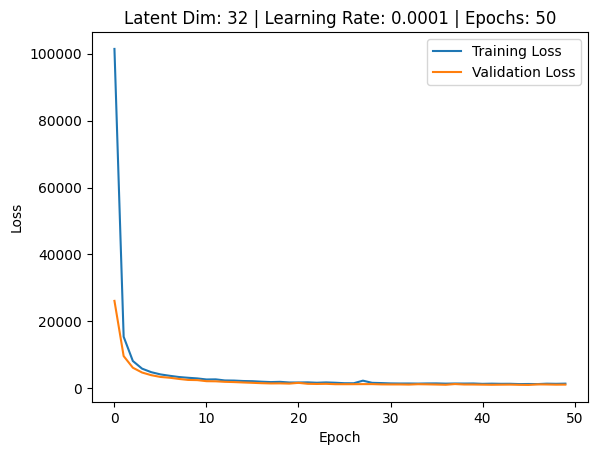

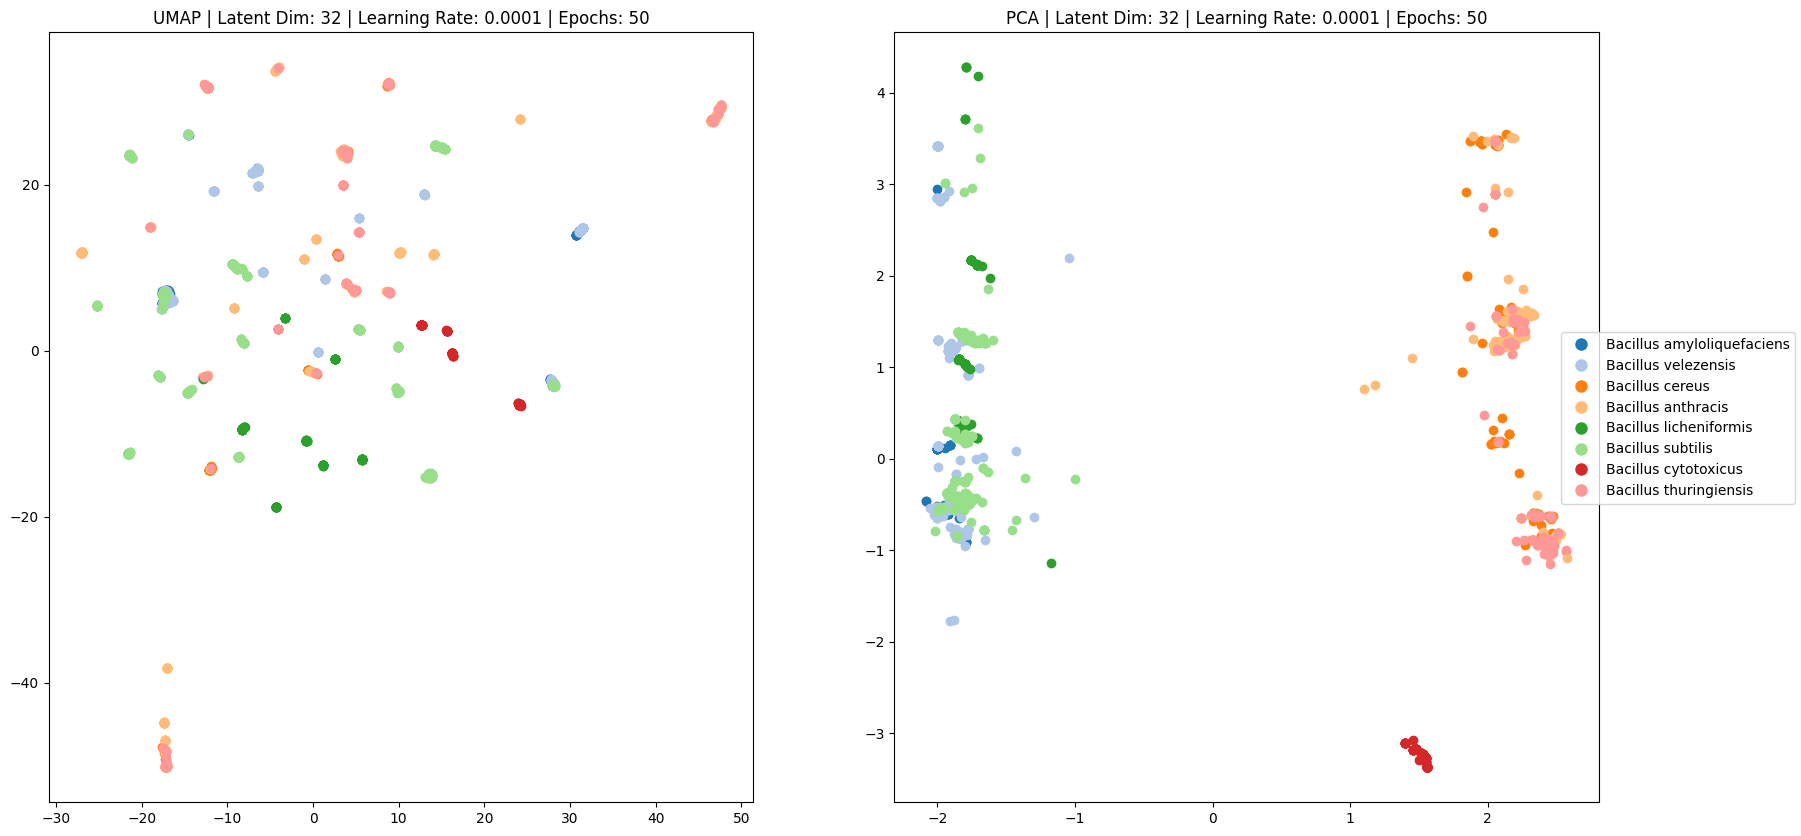

<ipython-input-9-579d99752fda>:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  loss_values = loss_values.append({


Epoch: 1 	Training Loss: 166696.605960 	Validation Loss: 134238.296630
Epoch: 2 	Training Loss: 121545.318435 	Validation Loss: 101628.429717
Epoch: 3 	Training Loss: 79840.259431 	Validation Loss: 54386.906636
Epoch: 4 	Training Loss: 41977.115529 	Validation Loss: 32634.593958
Epoch: 5 	Training Loss: 28852.964663 	Validation Loss: 25092.132931
Epoch: 6 	Training Loss: 23132.009781 	Validation Loss: 20862.922350
Epoch: 7 	Training Loss: 19517.402904 	Validation Loss: 17954.518800
Epoch: 8 	Training Loss: 16884.590126 	Validation Loss: 15643.745130
Epoch: 9 	Training Loss: 14809.115526 	Validation Loss: 13811.351709
Epoch: 10 	Training Loss: 13133.953517 	Validation Loss: 12304.234776
Epoch: 11 	Training Loss: 11774.499842 	Validation Loss: 11098.266711
Epoch: 12 	Training Loss: 10669.375286 	Validation Loss: 10101.431748
Epoch: 13 	Training Loss: 9749.423273 	Validation Loss: 9307.246198
Epoch: 14 	Training Loss: 9007.435196 	Validation Loss: 8584.374452
Epoch: 15 	Training Loss: 834

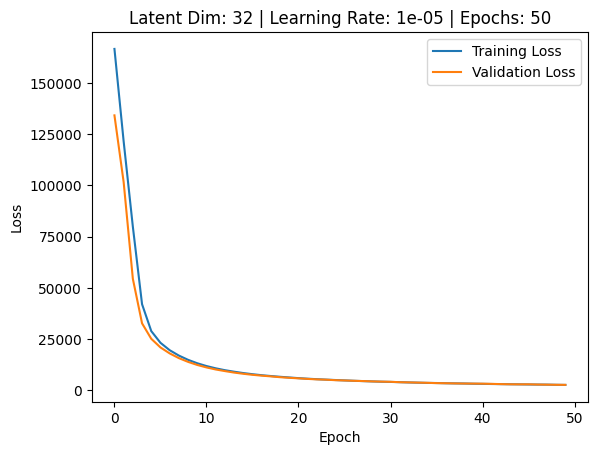

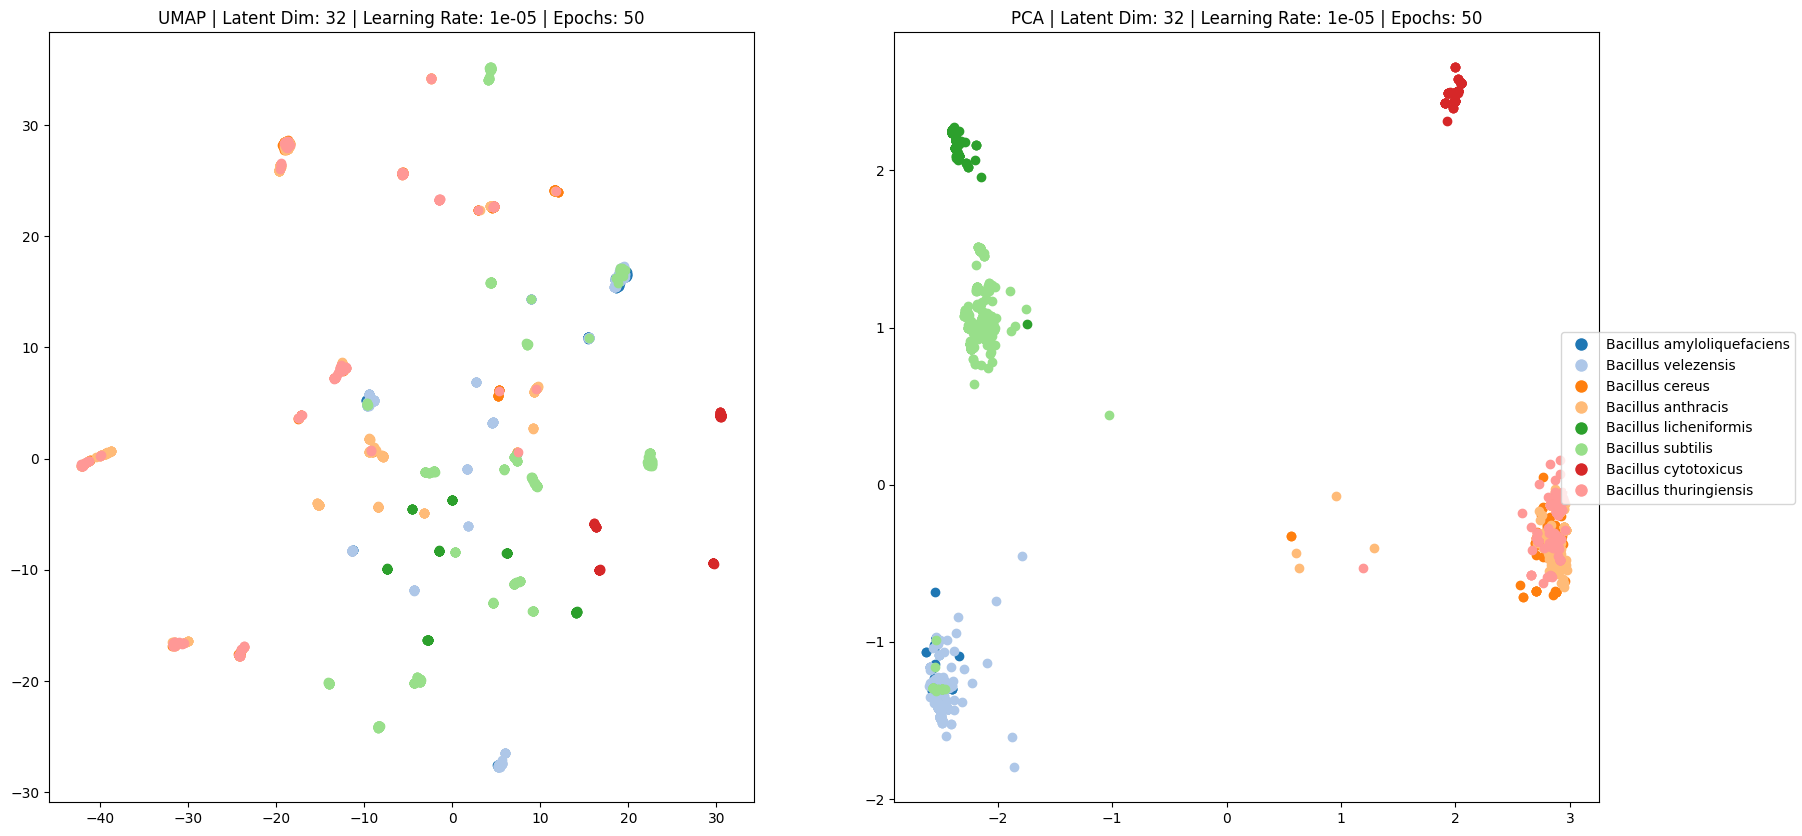

<ipython-input-9-579d99752fda>:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  loss_values = loss_values.append({
<ipython-input-9-579d99752fda>:68: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  train_loss_pivot = loss_values.pivot("latent_dim", "learning_rate", "final_train_loss")


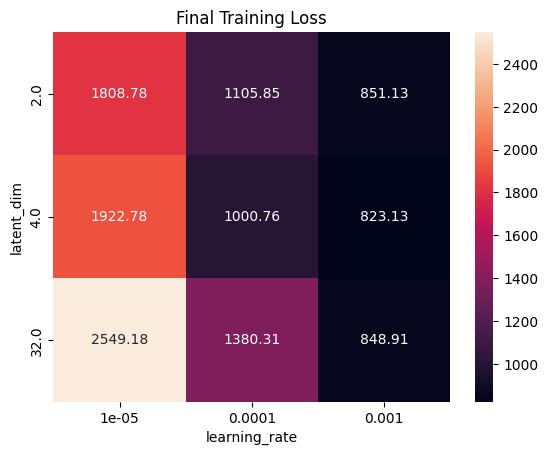

<ipython-input-9-579d99752fda>:74: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  val_loss_pivot = loss_values.pivot("latent_dim", "learning_rate", "final_val_loss")


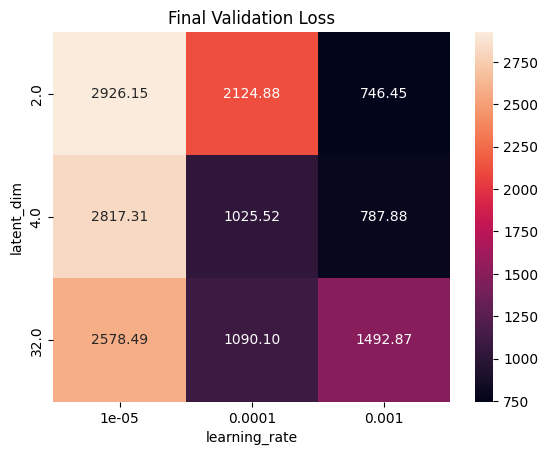

In [ ]:
def main(alignment_length, latent_dim, learning_rate, n_epochs): #, architecture_name):
    # Instantiate the model with the chosen architecture
    model = VariationalAutoencoder(input_length=alignment_length, latent_dim=latent_dim) #, architecture=architectures[architecture_name])
    model = model.to(device)

    # Define the optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Define the dataloader
    dataset = SequenceDataset(flatted_sequence)
    
    # Split the dataset into training and validation sets
    train_set, val_set = train_test_split(dataset, test_size=0.1)
    
    train_dataloader = DataLoader(train_set, batch_size=32, shuffle=True)
    val_dataloader = DataLoader(val_set, batch_size=32, shuffle=False)

    # Train the model
    train_losses, val_losses = train_model(model, optimizer, train_dataloader, val_dataloader, device, n_epochs)

    # Define the hyperparameters dictionary
    hyperparameters = {
        'latent_dim': latent_dim,
        'learning_rate': learning_rate,
        'n_epochs': n_epochs
    }

    plot_loss(train_losses, val_losses, hyperparameters)
    
    # Plot the latent space
    plot_latent_space(model, device, flatted_sequence, sequence_labels, latent_dim, hyperparameters)

    # Return the model and the final loss values
    final_train_loss = train_losses[-1]
    final_val_loss = val_losses[-1]

    return model, final_train_loss, final_val_loss

import pandas as pd
import seaborn as sns

if __name__ == '__main__':
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    alignment_length = 1500
    n_epochs = 50

    latent_dims = [2,4,32]
    learning_rates = [0.001,0.0001,0.00001]

    # Create a DataFrame to store the final loss values
    loss_values = pd.DataFrame(columns=["latent_dim", "learning_rate", "final_train_loss", "final_val_loss"])

    for latent_dim in latent_dims:
        for learning_rate in learning_rates:
            model, final_train_loss, final_val_loss = main(alignment_length, latent_dim, learning_rate, n_epochs)
            del model
            torch.cuda.empty_cache()

            # Append the final loss values to the DataFrame
            loss_values = loss_values.append({
                "latent_dim": latent_dim,
                "learning_rate": learning_rate,
                "final_train_loss": final_train_loss,
                "final_val_loss": final_val_loss
            }, ignore_index=True)

    # Plot a heatmap of the final training loss values
    train_loss_pivot = loss_values.pivot("latent_dim", "learning_rate", "final_train_loss")
    sns.heatmap(train_loss_pivot, annot=True, fmt=".2f")
    plt.title("Final Training Loss")
    plt.show()

    # Plot a heatmap of the final validation loss values
    val_loss_pivot = loss_values.pivot("latent_dim", "learning_rate", "final_val_loss")
    sns.heatmap(val_loss_pivot, annot=True, fmt=".2f")
    plt.title("Final Validation Loss")
    plt.show()